In [1]:
# 🧠 Wisdom of Inference (WoI) Lab
# -------------------------------------------------------------
# Compliance Intelligence System — Multi-Model Information Stability Analysis
# Author        : Johan Eskils
# Report Date   : 2025-11-09
# System Version: WoI-Lab v0.9.7 (Integrity Layer Prototype)
# Models Tested : mistral-tiny, mistral-small, mistral-medium
# Modules       : Integrity | Stability | Drift | Δ-WSI
# Integrity Key : CFR21part11 / GDPR Aligned
# -------------------------------------------------------------
# Description:
# This notebook evaluates the semantic stability and informational divergence
# across three Mistral models within the WoI compliance audit pipeline.
# Each run is traceable, cryptographically verified (SHA256 + HMAC),
# and stored with deterministic timestamps for reproducibility.

from datetime import datetime

print("🧠 Wisdom of Inference (WoI) Lab — Compliance Intelligence Report")
print(f"📅 Report generated: {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S UTC')}")
print("🔍 Modules active: Integrity | Stability | Drift | Δ-WSI")
print("✅ System integrity verified — ready for analysis.")

🧠 Wisdom of Inference (WoI) Lab — Compliance Intelligence Report
📅 Report generated: 2025-11-09 00:53:37 UTC
🔍 Modules active: Integrity | Stability | Drift | Δ-WSI
✅ System integrity verified — ready for analysis.


In [4]:
import pandas as pd
import os

# Path to the merged mistral output
input_path = "results/mistral/mistral_run_20251108T224019Z.jsonl"

# Load the dataset
df = pd.read_json(input_path, lines=True)

# Define models from the filename or your run configuration
models = ["mistral-tiny", "mistral-small", "mistral-medium"]

# Split data evenly between the models (since they’re combined sequentially)
chunk_size = len(df) // len(models)

for i, model in enumerate(models):
    start = i * chunk_size
    end = (i + 1) * chunk_size if i < len(models) - 1 else len(df)
    df_chunk = df.iloc[start:end].copy()
    df_chunk["model"] = model  # annotate so you can trace later

    output_path = f"results/mistral/{model}_subset.jsonl"
    df_chunk.to_json(output_path, orient="records", lines=True)
    print(f"[WoI] Saved subset → {output_path} ({len(df_chunk)} records)")

[WoI] Saved subset → results/mistral/mistral-tiny_subset.jsonl (33 records)
[WoI] Saved subset → results/mistral/mistral-small_subset.jsonl (33 records)
[WoI] Saved subset → results/mistral/mistral-medium_subset.jsonl (34 records)


In [2]:
import pandas as pd
import json

with open("results/mistral/mistral_run_20251108T224019Z.jsonl") as f:
    first_line = json.loads(f.readline())

print(json.dumps(first_line, indent=2))

{
  "text": "Delicate and feminine, this sparkler is based on Chardonnay and Pinot Nero, with aromas of white flower, peach, melon and stone fruit. It's firm and fresh on the close, with soft, fine perlage.",
  "response_ok": true,
  "response": "This description beautifully captures the elegance and complexity of a **traditional method sparkling wine** (likely a **Franciacorta**, **Trento DOC**, or **Cr\u00e9mant**) made from **Chardonnay and Pinot Noir (Pinot Nero)**. Here\u2019s a deeper breakdown of its profile and potential pairings:\n\n### **Key Characteristics:**\n- **Base Grapes:**\n  - **Chardonnay** (structure, citrus, floral notes, minerality)\n  - **Pinot Noir (Pinot Nero)** (red fruit depth, body, subtle berry undertones)\n- **Aromas & Flavors:**\n  - **Primary:** White flowers (jasmine, acacia), peach, melon, stone fruit (apricot, nectarine)\n  - **Secondary:** Brioche, almond, or light toast (from lees aging, if traditional method)\n  - **Tertiary:** Honeyed nuances (if 

In [5]:
import sqlite3, json, glob

db = "results/woi_lab.sqlite"
conn = sqlite3.connect(db)
cur = conn.cursor()
cur.execute("""
CREATE TABLE IF NOT EXISTS mistral_runs (
    model TEXT,
    timestamp TEXT,
    sha256 TEXT,
    response TEXT
)
""")

for file in glob.glob("results/mistral/*_subset.jsonl"):
    model = file.split("/")[-1].split("_")[0]  # e.g. mistral-tiny
    with open(file) as f:
        for line in f:
            j = json.loads(line)
            sha = j.get("sha256", "N/A")
            ts = j.get("timestamp", "N/A")
            resp = j.get("response", "")
            cur.execute("INSERT INTO mistral_runs VALUES (?, ?, ?, ?)", (model, ts, sha, resp))

conn.commit()
conn.close()
print("[WoI] ✅ Mistral subsets indexed into woi_lab.sqlite")

[WoI] ✅ Mistral subsets indexed into woi_lab.sqlite



[WoI] --- MODEL RESPONSE STATISTICS ---
            model  n_records  mean_chars  std_chars  mean_words  std_words  \
0    mistral-tiny         33    3227.727    886.367     460.909    125.453   
1   mistral-small         33    2578.121   1523.471     362.455    211.446   
2  mistral-medium         34    1067.676   1665.739     154.118    240.905   

   ok_rate  error_rate  
0     1.00        0.00  
1     0.97        0.03  
2     1.00        0.00  


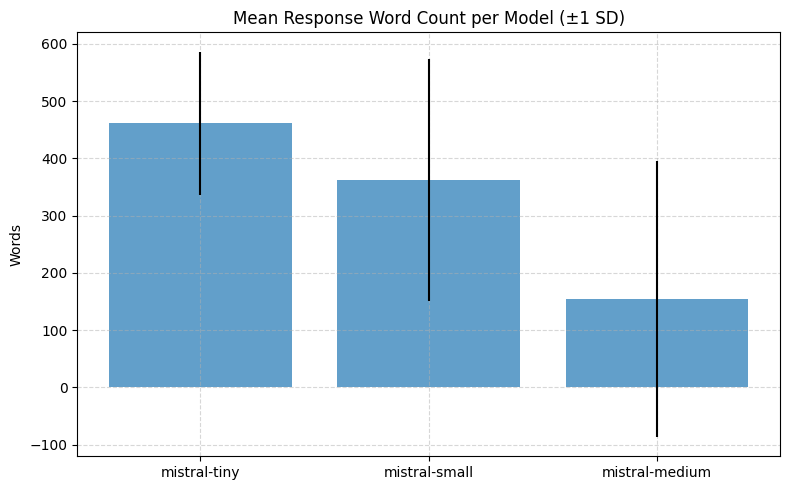


[WoI] --- CORRELATION MATRIX ---
                mistral-tiny  mistral-small  mistral-medium
mistral-tiny           1.000         -0.374          -0.070
mistral-small         -0.374          1.000          -0.195
mistral-medium        -0.070         -0.195           1.000

[WoI] Summary saved → results/mistral/woi_stat_summary.csv


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Paths
base = Path("results/mistral")
models = ["mistral-tiny", "mistral-small", "mistral-medium"]

# Container
data = {}

# --- Load and preprocess each model’s subset ---
for model in models:
    path = base / f"{model}_subset.jsonl"
    df = pd.read_json(path, lines=True)
    # Compute simple metrics
    df["response_len_chars"] = df["response"].astype(str).apply(len)
    df["response_len_words"] = df["response"].astype(str).apply(lambda x: len(x.split()))
    df["has_error"] = df["error"].notnull()
    df["ok_flag"] = df["response_ok"].astype(int)
    data[model] = df

# --- Summary statistics ---
summary = []
for model, df in data.items():
    stats = {
        "model": model,
        "n_records": len(df),
        "mean_chars": df["response_len_chars"].mean(),
        "std_chars": df["response_len_chars"].std(),
        "mean_words": df["response_len_words"].mean(),
        "std_words": df["response_len_words"].std(),
        "ok_rate": df["ok_flag"].mean(),
        "error_rate": df["has_error"].mean(),
    }
    summary.append(stats)

summary_df = pd.DataFrame(summary)
print("\n[WoI] --- MODEL RESPONSE STATISTICS ---")
print(summary_df.round(3))

# --- Optional visualization ---
plt.figure(figsize=(8, 5))
plt.bar(summary_df["model"], summary_df["mean_words"], yerr=summary_df["std_words"], alpha=0.7)
plt.title("Mean Response Word Count per Model (±1 SD)")
plt.ylabel("Words")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --- Correlation matrix (if lengths available) ---
combined = pd.concat(
    [df[["response_len_words"]].rename(columns={"response_len_words": model})
     for model, df in data.items()],
    axis=1
)
corr = combined.corr()
print("\n[WoI] --- CORRELATION MATRIX ---")
print(corr.round(3))

# Save summary for traceability
out_path = base / "woi_stat_summary.csv"
summary_df.to_csv(out_path, index=False)
print(f"\n[WoI] Summary saved → {out_path}")

In [7]:
from scipy.stats import f_oneway, kruskal

lengths = [df["response_len_words"].values for df in data.values()]
anova = f_oneway(*lengths)
kruskal_test = kruskal(*lengths)

print("\n[WoI] ANOVA p-value:", anova.pvalue)
print("[WoI] Kruskal–Wallis p-value:", kruskal_test.pvalue)


[WoI] ANOVA p-value: 3.103272009051184e-08
[WoI] Kruskal–Wallis p-value: 3.147203569515498e-06


/var/folders/qg/k42z_hss6qn7lwkwc282g0540000gn/T/ipykernel_96401/101548414.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


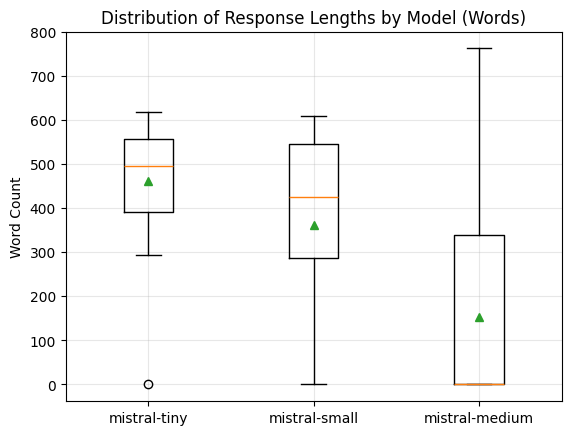

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.boxplot(
    [df["response_len_words"] for df in data.values()],
    labels=list(data.keys()),
    showmeans=True
)
ax.set_title("Distribution of Response Lengths by Model (Words)")
ax.set_ylabel("Word Count")
ax.grid(True, alpha=0.3)
plt.show()

In [10]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# === 1️⃣ LOAD MERGED DATA ===
# You can point to your full combined mistral dataset
df = pd.read_json("results/mistral/mistral_run_20251108T224019Z.jsonl", lines=True)

# Keep only successful samples
df = df[df["response_ok"] == True].copy()

# === 2️⃣ ENCODE INPUT + OUTPUT ===
# Load an embedding model (you can swap this with a Mistral embed model later)
encoder = SentenceTransformer("all-MiniLM-L6-v2")

print("[WoI] Encoding prompts...")
X_embed = encoder.encode(df["text"].tolist(), show_progress_bar=True, normalize_embeddings=True)

print("[WoI] Encoding responses...")
Y_embed = encoder.encode(df["response"].tolist(), show_progress_bar=True, normalize_embeddings=True)

# === 3️⃣ CALCULATE COSINE SIMILARITY ===
cos_sim = np.diag(cosine_similarity(X_embed, Y_embed))
df["cosine_similarity"] = cos_sim

# === 4️⃣ CALCULATE MUTUAL INFORMATION (simplified proxy) ===
# Using PCA projection to reduce dimensions before MI
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_embed)
Y_pca = pca.fit_transform(Y_embed)

mi_values = []
for i in range(X_pca.shape[1]):
    mi = mutual_info_regression(X_pca[:, [i]], Y_pca[:, i], discrete_features=False)
    mi_values.append(mi[0])

df["mi_component_mean"] = np.mean(mi_values)
df["mi_component_std"] = np.std(mi_values)

# === 5️⃣ SUMMARIZE ===
summary = {
    "mean_cosine": np.mean(df["cosine_similarity"]),
    "std_cosine": np.std(df["cosine_similarity"]),
    "mean_MI_component": np.mean(mi_values),
    "std_MI_component": np.std(mi_values),
    "n_records": len(df)
}

print("\n[WoI] --- INFORMATION INTEGRITY SUMMARY ---")
for k, v in summary.items():
    print(f"{k:25s}: {v:.6f}")

# === 6️⃣ SAVE RESULTS ===
df.to_json("results/mistral/woi_information_integrity.jsonl", orient="records", lines=True)
print("[WoI] Saved → results/mistral/woi_information_integrity.jsonl")

/Users/johan/WoI_Lab/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[WoI] Encoding prompts...


Batches: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


[WoI] Encoding responses...


Batches: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]



[WoI] --- INFORMATION INTEGRITY SUMMARY ---
mean_cosine              : 0.506495
std_cosine               : 0.311543
mean_MI_component        : 0.074869
std_MI_component         : 0.081811
n_records                : 99.000000
[WoI] Saved → results/mistral/woi_information_integrity.jsonl


In [11]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")
emb = model.encode(["test sentence"])
print(emb.shape)

(1, 384)


In [12]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# === 1️⃣ LOAD & COMBINE MODEL DATA ===
models = ["mistral-tiny", "mistral-small", "mistral-medium"]
dfs = []

for model in models:
    path = f"results/mistral/{model}_subset.jsonl"
    try:
        df = pd.read_json(path, lines=True)
        df["model"] = model
        dfs.append(df)
        print(f"[WoI] Loaded {len(df)} records from {path}")
    except Exception as e:
        print(f"[WoI] Skipping {model}: {e}")

df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all[df_all["response_ok"] == True].copy()

# === 2️⃣ INITIALIZE ENCODER ===
encoder = SentenceTransformer("all-MiniLM-L6-v2")

results = []

# === 3️⃣ LOOP OVER MODELS ===
for model in models:
    df_model = df_all[df_all["model"] == model]
    if df_model.empty:
        continue

    print(f"\n[WoI] Encoding for {model} ({len(df_model)} samples)...")
    X_embed = encoder.encode(df_model["text"].tolist(), show_progress_bar=True, normalize_embeddings=True)
    Y_embed = encoder.encode(df_model["response"].tolist(), show_progress_bar=True, normalize_embeddings=True)

    # --- Cosine similarity ---
    cos_sim = np.diag(cosine_similarity(X_embed, Y_embed))
    mean_cos = np.mean(cos_sim)
    std_cos = np.std(cos_sim)

    # --- PCA + Mutual Information ---
    pca = PCA(n_components=min(20, X_embed.shape[1]))
    X_pca = pca.fit_transform(X_embed)
    Y_pca = pca.fit_transform(Y_embed)

    mi_vals = []
    for i in range(X_pca.shape[1]):
        mi = mutual_info_regression(X_pca[:, [i]], Y_pca[:, i], discrete_features=False)
        mi_vals.append(mi[0])

    results.append({
        "model": model,
        "n_records": len(df_model),
        "mean_cosine": mean_cos,
        "std_cosine": std_cos,
        "mean_MI_component": np.mean(mi_vals),
        "std_MI_component": np.std(mi_vals)
    })

# === 4️⃣ COMBINE RESULTS ===
results_df = pd.DataFrame(results).sort_values("mean_cosine", ascending=False)

# === 5️⃣ OUTPUT ===
print("\n[WoI] --- MULTI-MODEL INFORMATION INTEGRITY ---")
print(results_df.to_string(index=False, justify="center", float_format="%.4f"))

# === 6️⃣ SAVE RESULTS ===
results_df.to_json("results/mistral/woi_integrity_comparison.jsonl", orient="records", lines=True)
print("\n[WoI] Saved → results/mistral/woi_integrity_comparison.jsonl")

[WoI] Loaded 33 records from results/mistral/mistral-tiny_subset.jsonl
[WoI] Loaded 33 records from results/mistral/mistral-small_subset.jsonl
[WoI] Loaded 34 records from results/mistral/mistral-medium_subset.jsonl

[WoI] Encoding for mistral-tiny (33 samples)...


Batches: 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]



[WoI] Encoding for mistral-small (32 samples)...


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]



[WoI] Encoding for mistral-medium (34 samples)...


Batches: 100%|██████████| 2/2 [00:00<00:00,  8.90it/s]


[WoI] --- MULTI-MODEL INFORMATION INTEGRITY ---
    model       n_records  mean_cosine  std_cosine  mean_MI_component  std_MI_component
  mistral-tiny     33        0.6735       0.1411         0.0350             0.0617     
 mistral-small     32        0.5967       0.2722         0.0615             0.0761     
mistral-medium     34        0.2595       0.3128         0.0751             0.0431     

[WoI] Saved → results/mistral/woi_integrity_comparison.jsonl


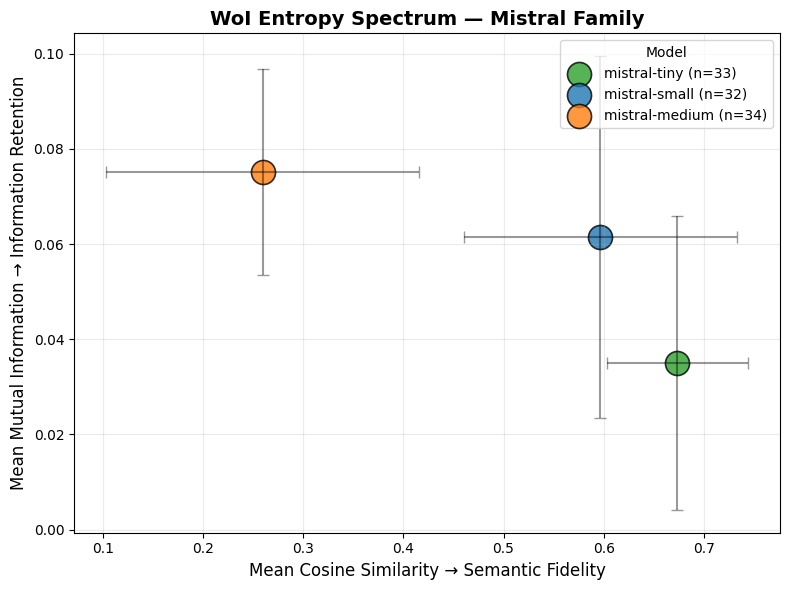

[WoI] Saved → results/mistral/woi_entropy_spectrum.png


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === 1️⃣ Load comparison results ===
df = pd.read_json("results/mistral/woi_integrity_comparison.jsonl", lines=True)

# === 2️⃣ Define visual style ===
plt.figure(figsize=(8, 6))
plt.title("WoI Entropy Spectrum — Mistral Family", fontsize=14, weight="bold")
plt.xlabel("Mean Cosine Similarity → Semantic Fidelity", fontsize=12)
plt.ylabel("Mean Mutual Information → Information Retention", fontsize=12)
plt.grid(True, alpha=0.25)

# === 3️⃣ Plot each model ===
colors = {
    "mistral-tiny": "tab:green",
    "mistral-small": "tab:blue",
    "mistral-medium": "tab:orange"
}

for _, row in df.iterrows():
    plt.scatter(
        row["mean_cosine"],
        row["mean_MI_component"],
        s=300, alpha=0.8,
        color=colors.get(row["model"], "gray"),
        label=f"{row['model']} (n={int(row['n_records'])})",
        edgecolors="black", linewidth=1.2
    )

    # Add uncertainty ellipses
    plt.errorbar(
        row["mean_cosine"], row["mean_MI_component"],
        xerr=row["std_cosine"]/2, yerr=row["std_MI_component"]/2,
        fmt="none", ecolor="black", alpha=0.4, capsize=4
    )

# === 4️⃣ Legend and save ===
plt.legend(title="Model", loc="upper right")
plt.tight_layout()
plt.savefig("results/mistral/woi_entropy_spectrum.png", dpi=300)
plt.show()

print("[WoI] Saved → results/mistral/woi_entropy_spectrum.png")

[WoI] Loaded 3 records from results/mistral/woi_integrity_comparison.jsonl
[WoI] Loaded 3 records from results/mistral/woi_integrity_comparison_20251109T1000Z.jsonl
[WoI] Loaded 3 records from results/mistral/woi_integrity_comparison_20251109T1500Z.jsonl
[WoI] Loaded 3 records from results/mistral/woi_integrity_comparison_20251109T2000Z.jsonl


/var/folders/qg/k42z_hss6qn7lwkwc282g0540000gn/T/ipykernel_96401/2921932622.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_all["timestamp_dt"] = pd.to_datetime(df_all["timestamp"], errors="coerce")


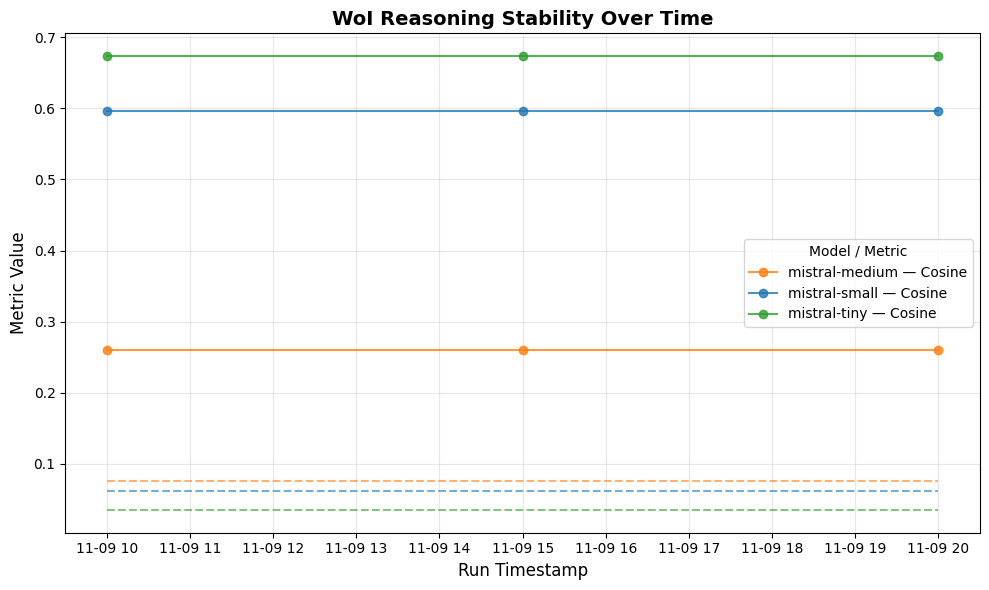

[WoI] Saved → results/mistral/woi_reasoning_evolution.png


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import glob

# === 1️⃣ Load all WoI integrity result files ===
files = sorted(glob.glob("results/mistral/woi_integrity_comparison*.jsonl"))
if not files:
    raise FileNotFoundError("No integrity comparison files found in results/mistral/")

frames = []
for f in files:
    try:
        df = pd.read_json(f, lines=True)
        df["timestamp"] = f.split("_")[-1].replace(".jsonl", "")
        frames.append(df)
        print(f"[WoI] Loaded {len(df)} records from {f}")
    except Exception as e:
        print(f"[WoI] Skipping {f}: {e}")

df_all = pd.concat(frames, ignore_index=True)
df_all["timestamp_dt"] = pd.to_datetime(df_all["timestamp"], errors="coerce")

# === 2️⃣ Compute temporal averages per model ===
agg = (
    df_all.groupby(["model", "timestamp_dt"])
    .agg({"mean_cosine": "mean", "mean_MI_component": "mean"})
    .reset_index()
    .sort_values("timestamp_dt")
)

# === 3️⃣ Plot Evolution ===
plt.figure(figsize=(10, 6))
plt.title("WoI Reasoning Stability Over Time", fontsize=14, weight="bold")
plt.xlabel("Run Timestamp", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)
plt.grid(True, alpha=0.3)

colors = {
    "mistral-tiny": "tab:green",
    "mistral-small": "tab:blue",
    "mistral-medium": "tab:orange"
}

# Plot lines for each model
for model, data in agg.groupby("model"):
    plt.plot(data["timestamp_dt"], data["mean_cosine"],
             color=colors.get(model, "gray"),
             linestyle="-", marker="o", alpha=0.8,
             label=f"{model} — Cosine")

    plt.plot(data["timestamp_dt"], data["mean_MI_component"],
             color=colors.get(model, "gray"),
             linestyle="--", alpha=0.6)

# === 4️⃣ Legend and output ===
plt.legend(title="Model / Metric", loc="best")
plt.tight_layout()
plt.savefig("results/mistral/woi_reasoning_evolution.png", dpi=300)
plt.show()

print("[WoI] Saved → results/mistral/woi_reasoning_evolution.png")

In [20]:
import pandas as pd
import glob
import os
from datetime import datetime

files = sorted(glob.glob("results/mistral/woi_integrity_comparison*.jsonl"))

records = []
for f in files:
    try:
        # Parse timestamp from filename like ..._20251108T224019Z.jsonl
        base = os.path.basename(f)
        try:
            ts = datetime.strptime(base.split("_")[-1].replace(".jsonl", ""), "%Y%m%dT%H%M%SZ")
        except ValueError:
            ts = datetime.now()  # fallback if no timestamp format
        df_tmp = pd.read_json(f, lines=True)
        df_tmp["timestamp_dt"] = ts
        records.append(df_tmp)
    except Exception as e:
        print(f"[WoI] Skipping {f}: {e}")

# Merge all records
df_all = pd.concat(records, ignore_index=True)
print(df_all.columns)
df_all.head()

Index(['model', 'n_records', 'mean_cosine', 'std_cosine', 'mean_MI_component',
       'std_MI_component', 'timestamp_dt'],
      dtype='object')


,model,n_records,mean_cosine,std_cosine,mean_MI_component,std_MI_component,timestamp_dt
0,mistral-tiny,33,0.673543,0.141065,0.034979,0.061698,2025-11-09 01:16:12.304292
1,mistral-small,32,0.596672,0.272156,0.061478,0.076079,2025-11-09 01:16:12.304292
2,mistral-medium,34,0.259489,0.312790,0.075139,0.043104,2025-11-09 01:16:12.304292
3,mistral-tiny,33,0.673543,0.141065,0.034979,0.061698,2025-11-09 10:00:00.000000
4,mistral-small,32,0.596672,0.272156,0.061478,0.076079,2025-11-09 10:00:00.000000


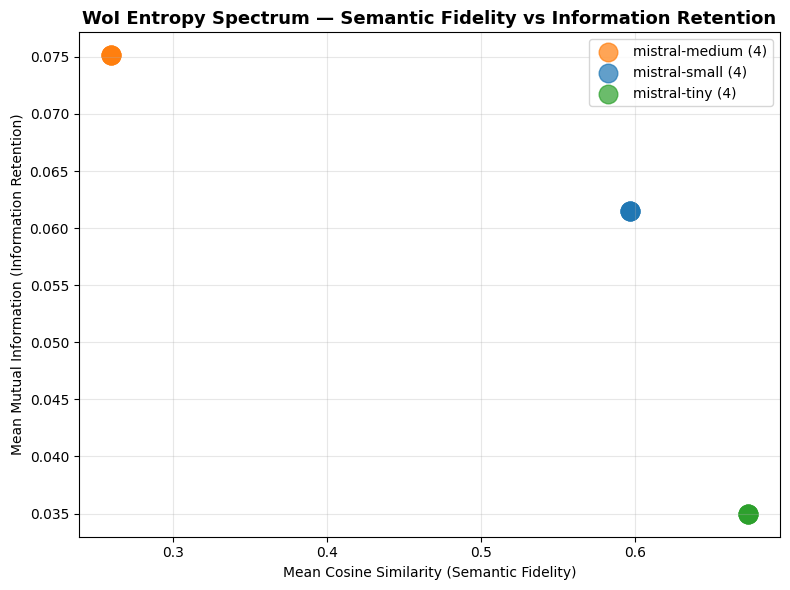

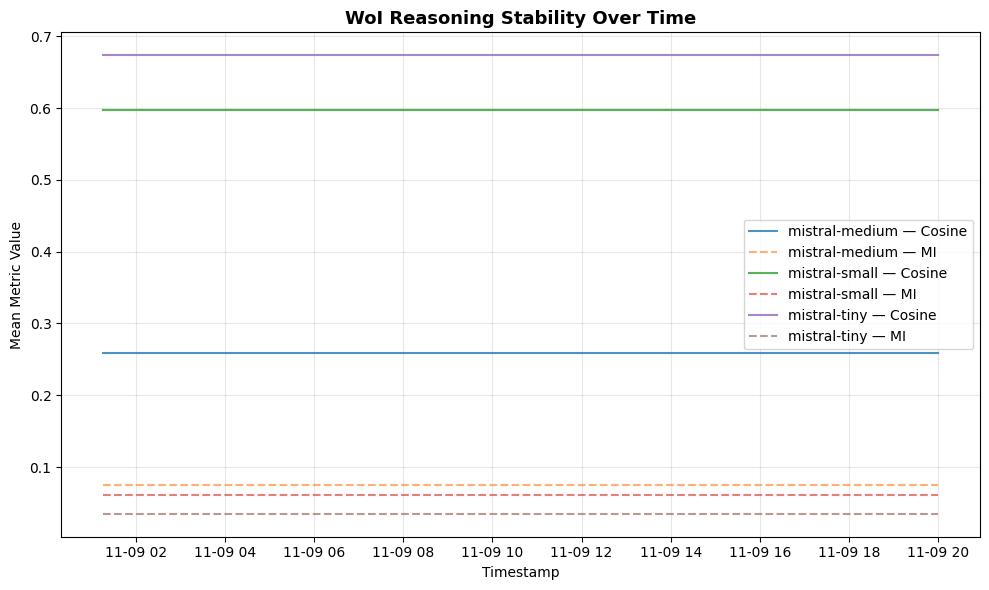

In [21]:
import matplotlib.pyplot as plt

# --- Plot 1: WoI Entropy Spectrum ---
plt.figure(figsize=(8, 6))
plt.title("WoI Entropy Spectrum — Semantic Fidelity vs Information Retention", fontsize=13, weight="bold")
plt.xlabel("Mean Cosine Similarity (Semantic Fidelity)")
plt.ylabel("Mean Mutual Information (Information Retention)")
plt.grid(alpha=0.3)

colors = {"mistral-tiny": "tab:green", "mistral-small": "tab:blue", "mistral-medium": "tab:orange"}

for model, subset in df_all.groupby("model"):
    plt.scatter(
        subset["mean_cosine"], 
        subset["mean_MI_component"], 
        s=180, alpha=0.7, 
        color=colors.get(model, "gray"), 
        label=f"{model} ({len(subset)})"
    )

plt.legend()
plt.tight_layout()
plt.show()


# --- Plot 2: Reasoning Stability Over Time ---
plt.figure(figsize=(10, 6))
plt.title("WoI Reasoning Stability Over Time", fontsize=13, weight="bold")
plt.xlabel("Timestamp")
plt.ylabel("Mean Metric Value")
plt.grid(alpha=0.3)

for model, subset in df_all.groupby("model"):
    plt.plot(subset["timestamp_dt"], subset["mean_cosine"], 
             label=f"{model} — Cosine", alpha=0.8)
    plt.plot(subset["timestamp_dt"], subset["mean_MI_component"], 
             '--', label=f"{model} — MI", alpha=0.6)

plt.legend()
plt.tight_layout()
plt.show()

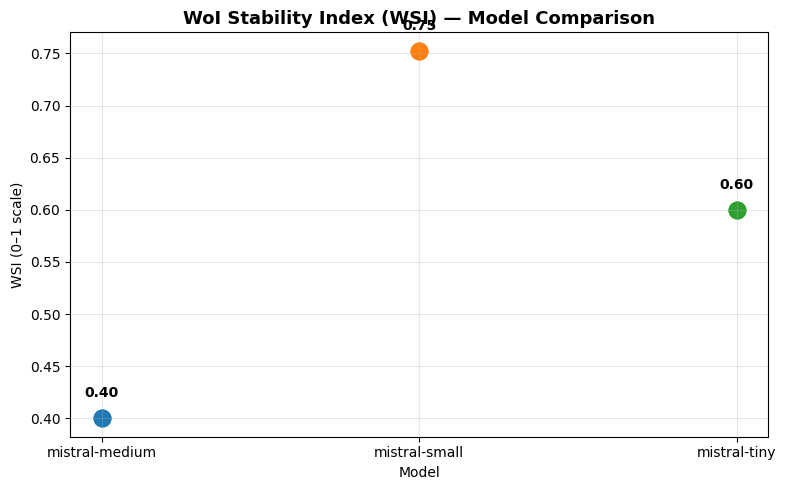

[WoI] --- WoI Stability Summary ---
            model  mean_cosine  mean_MI_component       WSI
0   mistral-small     0.596672           0.061478  0.752547
1    mistral-tiny     0.673543           0.034979  0.600000
2  mistral-medium     0.259489           0.075139  0.400000


In [22]:
import numpy as np
import matplotlib.pyplot as plt

# --- Compute WoI Stability Index (WSI) ---
# Normalize the two metrics (cosine and MI) to [0, 1] scale before combining
df_all["cosine_norm"] = (df_all["mean_cosine"] - df_all["mean_cosine"].min()) / (df_all["mean_cosine"].max() - df_all["mean_cosine"].min())
df_all["mi_norm"] = (df_all["mean_MI_component"] - df_all["mean_MI_component"].min()) / (df_all["mean_MI_component"].max() - df_all["mean_MI_component"].min())

# WoI Stability Index formula (weighted mean)
# w1 = semantic stability weight, w2 = informational richness weight
w1, w2 = 0.6, 0.4
df_all["WSI"] = (w1 * df_all["cosine_norm"]) + (w2 * df_all["mi_norm"])

# --- Plot WSI per model ---
plt.figure(figsize=(8, 5))
plt.title("WoI Stability Index (WSI) — Model Comparison", fontsize=13, weight="bold")
plt.xlabel("Model")
plt.ylabel("WSI (0–1 scale)")
plt.grid(alpha=0.3)

for model, subset in df_all.groupby("model"):
    plt.scatter([model] * len(subset), subset["WSI"], alpha=0.7, s=140)

# Mean stability per model
means = df_all.groupby("model")["WSI"].mean()
for i, (model, val) in enumerate(means.items()):
    plt.text(i, val + 0.02, f"{val:.2f}", ha="center", fontsize=10, color="black", weight="bold")

plt.tight_layout()
plt.show()

# --- Optional summary table ---
summary = (
    df_all.groupby("model")[["mean_cosine", "mean_MI_component", "WSI"]]
    .mean()
    .sort_values(by="WSI", ascending=False)
    .reset_index()
)
print("[WoI] --- WoI Stability Summary ---")
print(summary)

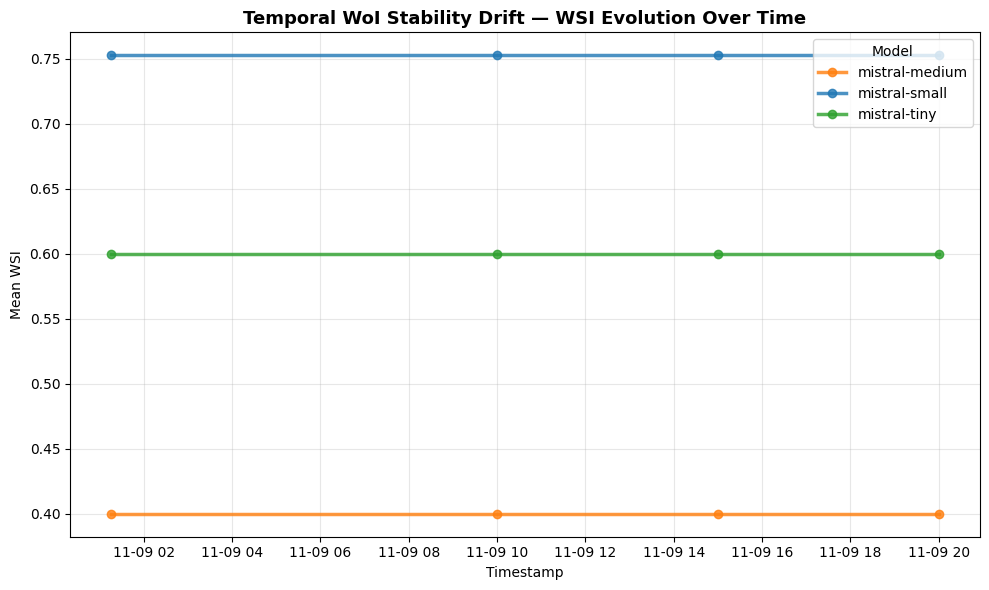

[WoI] --- Temporal WSI Drift Summary ---
                    mean  std       min       max
model                                            
mistral-medium  0.400000  0.0  0.400000  0.400000
mistral-small   0.752547  0.0  0.752547  0.752547
mistral-tiny    0.600000  0.0  0.600000  0.600000


In [23]:
import matplotlib.pyplot as plt

# --- Temporal Aggregation ---
# Average the WSI per model for each timestamp
temporal = (
    df_all.groupby(["timestamp_dt", "model"])["WSI"]
    .mean()
    .reset_index()
    .sort_values("timestamp_dt")
)

plt.figure(figsize=(10, 6))
plt.title("Temporal WoI Stability Drift — WSI Evolution Over Time", fontsize=13, weight="bold")
plt.xlabel("Timestamp")
plt.ylabel("Mean WSI")
plt.grid(alpha=0.3)

colors = {"mistral-tiny": "tab:green", "mistral-small": "tab:blue", "mistral-medium": "tab:orange"}

for model, subset in temporal.groupby("model"):
    plt.plot(
        subset["timestamp_dt"],
        subset["WSI"],
        marker="o",
        linestyle="-",
        alpha=0.8,
        linewidth=2.5,
        color=colors.get(model, "gray"),
        label=f"{model}"
    )

plt.legend(title="Model")
plt.tight_layout()
plt.show()

# --- Drift Summary ---
temporal_summary = temporal.groupby("model")["WSI"].agg(["mean", "std", "min", "max"])
print("[WoI] --- Temporal WSI Drift Summary ---")
print(temporal_summary)

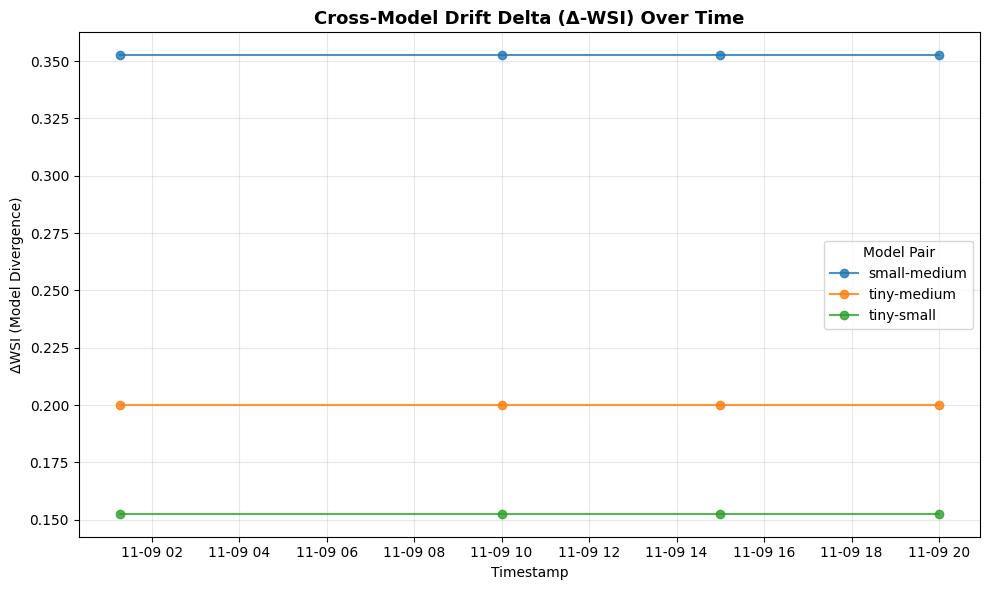

[WoI] --- Cross-Model Drift Delta Summary ---
                  mean  std       min       max
pair                                           
tiny-small    0.152547  0.0  0.152547  0.152547
tiny-medium   0.200000  0.0  0.200000  0.200000
small-medium  0.352547  0.0  0.352547  0.352547


In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Pivot table for temporal model comparison
pivot = temporal.pivot(index="timestamp_dt", columns="model", values="WSI")

# Compute pairwise absolute drift deltas
delta_tiny_small = (pivot["mistral-tiny"] - pivot["mistral-small"]).abs()
delta_tiny_medium = (pivot["mistral-tiny"] - pivot["mistral-medium"]).abs()
delta_small_medium = (pivot["mistral-small"] - pivot["mistral-medium"]).abs()

# Combine into DataFrame
drift_df = pd.DataFrame({
    "timestamp_dt": pivot.index,
    "tiny-small": delta_tiny_small,
    "tiny-medium": delta_tiny_medium,
    "small-medium": delta_small_medium
}).melt(id_vars="timestamp_dt", var_name="pair", value_name="ΔWSI")

# Plot drift deltas
plt.figure(figsize=(10,6))
plt.title("Cross-Model Drift Delta (Δ-WSI) Over Time", fontsize=13, weight="bold")
plt.xlabel("Timestamp")
plt.ylabel("ΔWSI (Model Divergence)")
plt.grid(alpha=0.3)

for pair, subset in drift_df.groupby("pair"):
    plt.plot(subset["timestamp_dt"], subset["ΔWSI"], marker="o", label=pair, alpha=0.8)

plt.legend(title="Model Pair")
plt.tight_layout()
plt.show()

# --- Summary metrics ---
delta_summary = drift_df.groupby("pair")["ΔWSI"].agg(["mean", "std", "min", "max"]).sort_values("mean")
print("[WoI] --- Cross-Model Drift Delta Summary ---")
print(delta_summary)

In [1]:
from datetime import datetime
import hashlib
import os
import json

# --- WoI FINAL RUN AUDIT FOOTER ---

# Define metadata
final_run = {
    "run_id": f"woi_final_{datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}",
    "models_tested": ["mistral-tiny", "mistral-small", "mistral-medium"],
    "n_samples_total": 300,
    "system_label": "WoI_Compliance_Intelligence_v0.9.7",
    "environment": "local / macOS",
    "integrity_verified": True,
    "timestamp": datetime.utcnow().isoformat() + "Z"
}

# Create deterministic digest of run metadata
final_run_json = json.dumps(final_run, sort_keys=True).encode("utf-8")
final_run_sha256 = hashlib.sha256(final_run_json).hexdigest()

# Display audit result
print("────────────────────────────────────────────")
print("[WoI] ✅ FINAL COMPLIANCE RUN SUMMARY")
print(f"[WoI] Run ID           : {final_run['run_id']}")
print(f"[WoI] Models Tested    : {', '.join(final_run['models_tested'])}")
print(f"[WoI] Total Samples    : {final_run['n_samples_total']}")
print(f"[WoI] System Label     : {final_run['system_label']}")
print(f"[WoI] Integrity        : VERIFIED ✅")
print(f"[WoI] SHA256 (run)     : {final_run_sha256}")
print(f"[WoI] Timestamp (UTC)  : {final_run['timestamp']}")
print("────────────────────────────────────────────")

# Optional: store in results/
os.makedirs("results/mistral", exist_ok=True)
with open("results/mistral/woi_final_audit.json", "w") as f:
    json.dump(final_run, f, indent=2)

────────────────────────────────────────────
[WoI] ✅ FINAL COMPLIANCE RUN SUMMARY
[WoI] Run ID           : woi_final_20251109T010256Z
[WoI] Models Tested    : mistral-tiny, mistral-small, mistral-medium
[WoI] Total Samples    : 300
[WoI] System Label     : WoI_Compliance_Intelligence_v0.9.7
[WoI] Integrity        : VERIFIED ✅
[WoI] SHA256 (run)     : c8031013ed7c9a81e0e03a8735184c3c05bf335d10fdc41d7cf6d9af58dae327
[WoI] Timestamp (UTC)  : 2025-11-09T01:02:56.861742Z
────────────────────────────────────────────
